In [1]:
import numpy as np 
import pandas as pd 
import os
import torch
import torch.nn as nn
import torchvision
from torch.autograd import Variable
from torchvision import transforms
from PIL import Image
from torch.utils.data import Dataset, DataLoader
from pathlib import Path
import random

In [2]:
directory = "./PokemonData - aug"
labels = os.listdir(directory)
nb = len(labels)
print(labels)

['Abra', 'Aerodactyl', 'Alakazam', 'Arbok', 'Arcanine', 'Articuno', 'Beedrill', 'Bellsprout', 'Blastoise', 'Bulbasaur', 'Butterfree', 'Caterpie', 'Chansey', 'Charizard', 'Charmander', 'Charmeleon', 'Clefable', 'Clefairy', 'Cloyster', 'Cubone', 'Dewgong', 'Diglett', 'Ditto', 'Dodrio', 'Doduo', 'Dragonair', 'Dragonite', 'Dratini', 'Drowzee', 'Dugtrio', 'Eevee', 'Ekans', 'Electabuzz', 'Electrode', 'Exeggcute', 'Exeggutor', 'Farfetchd', 'Fearow', 'Flareon', 'Gastly', 'Gengar', 'Geodude', 'Gloom', 'Golbat', 'Goldeen', 'Golduck', 'Golem', 'Graveler', 'Grimer', 'Growlithe', 'Gyarados', 'Haunter', 'Hitmonchan', 'Hitmonlee', 'Horsea', 'Hypno', 'Ivysaur', 'Jigglypuff', 'Jolteon', 'Jynx', 'Kabuto', 'Kabutops', 'Kadabra', 'Kakuna', 'Kangaskhan', 'Kingler', 'Koffing', 'Krabby', 'Lapras', 'Lickitung', 'Machamp', 'Machoke', 'Machop', 'Magikarp', 'Magmar', 'Magnemite', 'Magneton', 'Mankey', 'Marowak', 'Meowth', 'Metapod', 'Mew', 'Mewtwo', 'Moltres', 'Muk', 'Nidoking', 'Nidoqueen', 'Nidorina', 'Nidorin

In [3]:
def input_target_split(train_dir,labels,stored_label):
    count = 0
    imgs = []
    for label in labels:  #[:3]
        folder = train_dir+"/"+label
        print(train_dir,label,folder)
        for image in os.listdir(folder):
            img_path= Path(folder+"/"+image)
            imgs.append((img_path,count))
        print(f'\rCompleted: {label}',end='')
        stored_label[label] = count
        print()
        count+=1
        
    return imgs
    
    
def default_loader(path):
    return Image.open(path).convert('RGB')

class MyDataset(Dataset):
    def __init__(self, imgs,transform=None, target_transform=None,loader=default_loader):
        self.transform = transform
        self.target_transform = target_transform
        self.loader = loader  
        
        self.imgs = imgs
    
    def get_imgs(self):
        return self.imgs
        
    def __getitem__(self, index):
        img_path,label = self.imgs[index]
        pil_img = self.loader(img_path)
        data = self.transform(pil_img)
        
        return data,label

    def __len__(self):
        return len(self.imgs)
    
transform=transforms.Compose([
    transforms.Resize((150, 150)),
    transforms.CenterCrop(150),
    transforms.ToTensor(),
    transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))
])

In [4]:
stored_label = {}
all_data = input_target_split(directory,labels,stored_label)

train_num = 0.8
train_size = int(train_num * len(all_data))
test_size = len(all_data) - train_size

train_dataset, test_dataset = torch.utils.data.random_split(all_data, [train_size, test_size])

train_data = MyDataset(train_dataset, transform)
test_data = MyDataset(test_dataset, transform)

train_loader = DataLoader(dataset=train_data, batch_size=64, shuffle=True) #train data
test_loader = DataLoader(dataset=test_data, batch_size=64)                 #test data

./PokemonData - aug Abra ./PokemonData - aug/Abra
Completed: Abra
./PokemonData - aug Aerodactyl ./PokemonData - aug/Aerodactyl
Completed: Aerodactyl
./PokemonData - aug Alakazam ./PokemonData - aug/Alakazam
Completed: Alakazam
./PokemonData - aug Arbok ./PokemonData - aug/Arbok
Completed: Arbok
./PokemonData - aug Arcanine ./PokemonData - aug/Arcanine
Completed: Arcanine
./PokemonData - aug Articuno ./PokemonData - aug/Articuno
Completed: Articuno
./PokemonData - aug Beedrill ./PokemonData - aug/Beedrill
Completed: Beedrill
./PokemonData - aug Bellsprout ./PokemonData - aug/Bellsprout
Completed: Bellsprout
./PokemonData - aug Blastoise ./PokemonData - aug/Blastoise
Completed: Blastoise
./PokemonData - aug Bulbasaur ./PokemonData - aug/Bulbasaur
Completed: Bulbasaur
./PokemonData - aug Butterfree ./PokemonData - aug/Butterfree
Completed: Butterfree
./PokemonData - aug Caterpie ./PokemonData - aug/Caterpie
Completed: Caterpie
./PokemonData - aug Chansey ./PokemonData - aug/Chansey
Compl

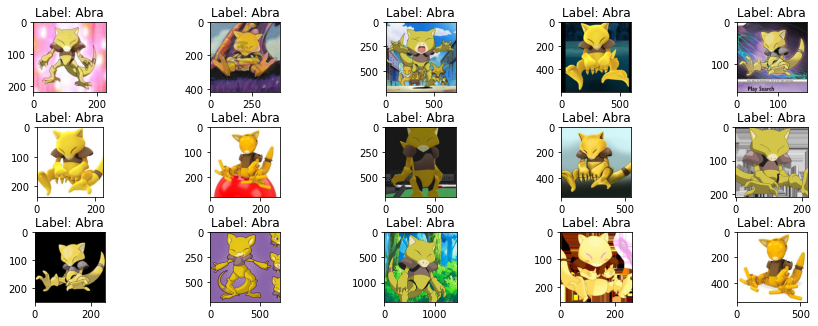

In [5]:
import matplotlib.pyplot as plt

plt.figure(figsize = (15 , 9))
n = 0

for i in range(15):
    n+=1
    plt.subplot(5 , 5, n)
    plt.subplots_adjust(hspace = 0.5 , wspace = 0.3)
    plt.imshow(Image.open(all_data[i][0]).convert('RGB'))
    plt.title(f'Label: {labels[all_data[i][1]]}')

In [6]:
device=torch.device("cuda" if torch.cuda.is_available() else 'cpu')

In [7]:
from torchvision import datasets, models
# 使用有预训练的resnet18
model=torchvision.models.resnet18(pretrained=True)
num_features=model.fc.in_features
model.fc=nn.Linear(num_features,150)
model=model.to(device)

In [8]:
learning_rate = 0.0001  
iteration_num = 15   
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
train_loss=[] 
test_acc=[] 

In [9]:
import torch.nn.functional as F

def train(model,epoch,train_loader):
    model.train()
    lr_dec=0.9**epoch*learning_rate 
    optimizer.lr=lr_dec
    for step,(x,y) in enumerate(train_loader):
        x,y=x.to(device),y.to(device)
        optimizer.zero_grad()
        output=model(x)
        loss=F.cross_entropy(output,y)
        loss.backward()
        train_loss.append(loss)
        optimizer.step()
        if step % 10 == 0:
            print('Epoch: {}, Step {}, Loss: {}'.format(epoch, step, loss))

In [10]:
def test(model,test_loader):
    model.eval()
    correct=0
    with torch.no_grad():
        for x, y in test_loader:
            x,y=x.to(device),y.to(device)
            output = model(x)
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(y.view_as(pred)).sum().item()
            
    accuracy = correct / len(test_loader.dataset) * 100
    print("Test Accuracy: {}%".format(accuracy))
    test_acc.append(accuracy)

In [11]:
for epoch in range(iteration_num):
    print("\n================ epoch: {} ================".format(epoch))
    train(model, epoch, train_loader)
    test(model, test_loader)


================ epoch: 0 ================
Epoch: 0, Step 0, Loss: 5.34150505065918
Epoch: 0, Step 10, Loss: 4.943948268890381
Epoch: 0, Step 20, Loss: 4.8913140296936035
Epoch: 0, Step 30, Loss: 4.459473133087158
Epoch: 0, Step 40, Loss: 4.349257469177246
Epoch: 0, Step 50, Loss: 3.922520399093628
Epoch: 0, Step 60, Loss: 3.451192617416382
Epoch: 0, Step 70, Loss: 3.3365190029144287
Epoch: 0, Step 80, Loss: 2.9354774951934814
Epoch: 0, Step 90, Loss: 3.0158679485321045
Epoch: 0, Step 100, Loss: 2.8907108306884766
Epoch: 0, Step 110, Loss: 2.584158182144165
Epoch: 0, Step 120, Loss: 2.491175889968872
Epoch: 0, Step 130, Loss: 2.253333568572998
Epoch: 0, Step 140, Loss: 2.090790033340454
Epoch: 0, Step 150, Loss: 2.0245728492736816
Epoch: 0, Step 160, Loss: 1.8976365327835083
Epoch: 0, Step 170, Loss: 1.4735398292541504
Epoch: 0, Step 180, Loss: 1.4754310846328735
Epoch: 0, Step 190, Loss: 1.724338412284851
Epoch: 0, Step 200, Loss: 1.6116074323654175
Epoch: 0, Step 210, Loss: 1.209119

Epoch: 4, Step 10, Loss: 0.01000227127224207
Epoch: 4, Step 20, Loss: 0.015375438146293163
Epoch: 4, Step 30, Loss: 0.014523464255034924
Epoch: 4, Step 40, Loss: 0.01548920851200819
Epoch: 4, Step 50, Loss: 0.012152399867773056
Epoch: 4, Step 60, Loss: 0.027115754783153534
Epoch: 4, Step 70, Loss: 0.00842071883380413
Epoch: 4, Step 80, Loss: 0.01011680904775858
Epoch: 4, Step 90, Loss: 0.009531530551612377
Epoch: 4, Step 100, Loss: 0.011611305177211761
Epoch: 4, Step 110, Loss: 0.04277501255273819
Epoch: 4, Step 120, Loss: 0.016929470002651215
Epoch: 4, Step 130, Loss: 0.01183795090764761
Epoch: 4, Step 140, Loss: 0.010622809641063213
Epoch: 4, Step 150, Loss: 0.01649537868797779
Epoch: 4, Step 160, Loss: 0.011317755095660686
Epoch: 4, Step 170, Loss: 0.008827490732073784
Epoch: 4, Step 180, Loss: 0.010602667927742004
Epoch: 4, Step 190, Loss: 0.008387673646211624
Epoch: 4, Step 200, Loss: 0.008772503584623337
Epoch: 4, Step 210, Loss: 0.011482077650725842
Epoch: 4, Step 220, Loss: 0.0

Test Accuracy: 96.5993465993466%

================ epoch: 8 ================
Epoch: 8, Step 0, Loss: 0.004047118593007326
Epoch: 8, Step 10, Loss: 0.0033342232927680016
Epoch: 8, Step 20, Loss: 0.0030356314964592457
Epoch: 8, Step 30, Loss: 0.004010706674307585
Epoch: 8, Step 40, Loss: 0.002651117742061615
Epoch: 8, Step 50, Loss: 0.004046913236379623
Epoch: 8, Step 60, Loss: 0.023186204954981804
Epoch: 8, Step 70, Loss: 0.0027954564429819584
Epoch: 8, Step 80, Loss: 0.0019961658399552107
Epoch: 8, Step 90, Loss: 0.00265188398770988
Epoch: 8, Step 100, Loss: 0.0032393373548984528
Epoch: 8, Step 110, Loss: 0.0040159448981285095
Epoch: 8, Step 120, Loss: 0.0027690723072737455
Epoch: 8, Step 130, Loss: 0.005946928169578314
Epoch: 8, Step 140, Loss: 0.003142820205539465
Epoch: 8, Step 150, Loss: 0.006209141109138727
Epoch: 8, Step 160, Loss: 0.00368203385733068
Epoch: 8, Step 170, Loss: 0.003059675684198737
Epoch: 8, Step 180, Loss: 0.0021550720557570457
Epoch: 8, Step 190, Loss: 0.0049005

Epoch: 11, Step 390, Loss: 0.03391016647219658
Epoch: 11, Step 400, Loss: 0.0030566107016056776
Epoch: 11, Step 410, Loss: 0.0036599652376025915
Epoch: 11, Step 420, Loss: 0.012068456970155239
Test Accuracy: 96.92604692604692%

================ epoch: 12 ================
Epoch: 12, Step 0, Loss: 0.001693414873443544
Epoch: 12, Step 10, Loss: 0.008265430107712746
Epoch: 12, Step 20, Loss: 0.0038639248814433813
Epoch: 12, Step 30, Loss: 0.0015274854376912117
Epoch: 12, Step 40, Loss: 0.001674241037108004
Epoch: 12, Step 50, Loss: 0.035724591463804245
Epoch: 12, Step 60, Loss: 0.0030188746750354767
Epoch: 12, Step 70, Loss: 0.11321692913770676
Epoch: 12, Step 80, Loss: 0.007971353828907013
Epoch: 12, Step 90, Loss: 0.001768197980709374
Epoch: 12, Step 100, Loss: 0.004536055494099855
Epoch: 12, Step 110, Loss: 0.00679787015542388
Epoch: 12, Step 120, Loss: 0.0012989956885576248
Epoch: 12, Step 130, Loss: 0.0011851786402985454
Epoch: 12, Step 140, Loss: 0.004122191108763218
Epoch: 12, Step 

In [12]:
model.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [13]:
loss_list=[]
for each in train_loss:
    loss_list.append(each.item())

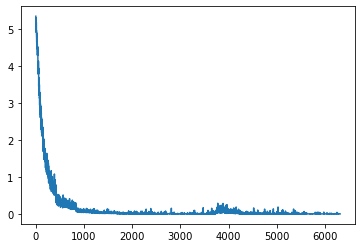

In [14]:
plt.plot(loss_list)

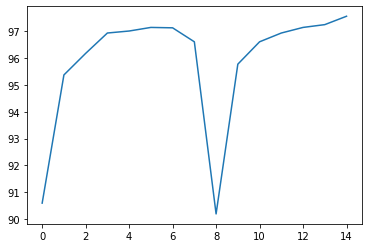

In [33]:
plt.plot(test_acc)

In [ ]:
import matplotlib.pyplot as plt
a=[90.5,]

In [16]:
img=Image.open('./PokemonData/Farfetchd/de17072e6baf4863be2e1b08a808bf4d.jpg').convert('RGB')
img=transform(img)
img = torch.unsqueeze(img, 0)
output=model(img.to(device))
print(labels[output.argmax(1)[0].item()])

Farfetchd


In [17]:
torch.save(model,'pokemon_model_aug.pth')

In [4]:
existing_model=torch.load('pokemon_model_aug.pth').to('cpu')
print(existing_model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [5]:
img=Image.open('./PokemonData/Charmander/00000038.png').convert('RGB')
img=transform(img)
img=torch.unsqueeze(img,0)
output=existing_model(img)
print(labels[output.argmax(1)[0].item()])

Charmander


In [10]:
import requests

name=labels[output.argmax(1)[0].item()]
url = f'https://pokeapi.co/api/v2/pokemon/{name.lower()}' 
r = requests.get(url)

In [12]:
dict={"Name: ":r.json()['name'],"Base Experience: ":r.json()['base_experience'],"Height: ":str(r.json()['height'])+'m',"Weight: ":str(r.json()['weight'])+'kg'}

In [13]:
print(dict)

{'Name: ': 'charmander', 'Base Experience: ': 62, 'Height: ': '6m', 'Weight: ': '85kg'}


In [30]:
print("Name: ",r.json()['name'])
print("Base Experience: ",r.json()['base_experience'])
print("Height: ",r.json()['height'],'m')
print("Weight: ",r.json()['weight'],'kg')

Name:  charmander
Base Experience:  62
Height:  6 m
Weight:  85 kg
